In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

## Grover's Algorithm

This notebook serves to implement Grover's Algorithm in a Jupyter Notebook. Grover's Algorithm is known as the quantum search algorithm. It is used to find a unique input to a black box function that produces a particular output value, or set of output values. Here we are creating a two qubit algorithm, but higher level algorithms are possible.



### Imports

First, we begin with a series of import statements. We need a number of general Python tools for plotting and analysis. We also need a number of tools from qiskit to create, run, and visualize our quantum circuit. 

In [15]:
# Python Tools

import matplotlib.pyplot as plt
import numpy as np
import time
import math

# Qiskit Tools

from qiskit import IBMQ, Aer, QuantumCircuit, ClassicalRegister
from qiskit import QuantumRegister, execute, transpile
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise

In [3]:
# Set devices, if using a real device
IBMQ.delete_account()
IBMQ.save_account("""4101635eabc8437b57ef9c94b5a86e7f6ac3a690e494525de9086b670dfb27307956d0240f5b27e0c80ed8c8ca48eb0d5fcab88d90d0719e06dd18add3e32a25""")
IBMQ.load_account()

provider = IBMQ.get_provider('ibm-q')
quito = provider.get_backend('ibmq_santiago')

3:80: E501 line too long (153 > 79 characters)


### Creating the Circuit

Now that the imports are complete, we want to initialize our quantum circuit. First, a few useful functions for creating our circuit elements are defined. We want to be able to inititalize our circuit, add an oracle matrix, and add a diffuser. It is also useful to have a function for repeatedly adding these circuit elements if we want to loop through the oracle matrix and diffuser. In this circuit, we want to make a state for the algorithm to recover. We begin by intitializing a two qubit circuit sent into a superposition by two Haddamard gates.

In [4]:
# Initialize a quantum circuit with a Haddamard Gate


def initial(Circ, Qubits):
    """Initializes the quantum circuit into a superposition
    with a Haddamard gate on each qubit. Takes a circuit and
    the qubits of the circuit as args.
    """
    for i in Qubits:
        Circ.h(i)
    return Circ


# Apply the oracle matrix to the circuit


def oracle(Circ, Qubits):
    """Applies the Oracle matrix to the quantum circuit.
    In our case, this is the controlled z gate onto each qubit.
    Takes a quantum circuit and the qubits of the circuit as args.
    """
    Circ.cz(Qubits[0], Qubits[1])
    return Circ


# Apply the diffuser to the matrix


def diffuse(Circ, Qubits):
    """Applies the diffuser onto the quantum circuit.
    In our case, this is a Haddamard, z , controlled z,
    and then another Haddamard gate in succession.
    Takes a quantum circuit and the qubits of the circuit as args.
    """
    for i in Qubits:
        Circ.h(i)
        Circ.z(i)
    oracle(Circ, Qubits)
    initial(Circ, Qubits)
    return Circ


# Apply the diffuser matrix a number of times equal to the Loops argument


def applyDiffuser(Circ, Qubits, Loops):
    """Applies the Oracle matrix and then the diffuser onto
    the quantum circuit a given number of times.
    Takes the loop count, a quantum circuit,
    and the qubits of the circuit as args."""
    for i in Loops:
        diffuse(Circ, Qubits)
    return Circ

In [5]:
# Create and set up the intial circuit

qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
grover_circ = QuantumCircuit(qreg_q, creg_c)
qubits = [0, 1]

initial(grover_circ, qubits)

In [6]:
# Visualize the circuit

grover_circ.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘
c: 2/═════

### Applying the Oracle Matrix and the Diffuser

Now we need to add the components onto this circuit to make it function as a two qubit Grover's Algorithm. These components are the Oracle Matrix and the Diffuser. The Oracle matrix serves to select the state that we want from the possible states. The diffuser then amplifies the probability of this state. In our case, the Oracle matrix is a controlled z gate, while the diffuser is a Haddamard, z, controlled z, and then another Haddamard gate in succession. These gates will be applied to each qubit.

In [8]:
# Create the CZ gate

oracle(grover_circ, qubits)

In [9]:
# Draw the Circuit

grover_circ.draw()

┌───┐   
q_0: ┤ H ├─■─
     ├───┤ │ 
q_1: ┤ H ├─■─
     └───┘   
c: 2/════════

In [10]:
# Apply the Diffuser

diffuse(grover_circ, qubits)

In [11]:
# Add Measurements

grover_circ.measure(qreg_q[0], creg_c[0])
grover_circ.measure(qreg_q[1], creg_c[1])

In [12]:
grover_circ.draw()

┌───┐   ┌───┐┌───┐   ┌───┐┌─┐   
q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├┤M├───
     ├───┤ │ ├───┤├───┤ │ ├───┤└╥┘┌─┐
q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├─╫─┤M├
     └───┘   └───┘└───┘   └───┘ ║ └╥┘
c: 2/═══════════════════════════╩══╩═
                                0  1

### Running the Circuit

Now that the circuit is properly set up, we can run it on a quantum computer. We use the tools and settings that we imported and initialized at the beginning of the notebook to now run this circuit on an IBM quantum computer 1024 times. This should give us a good idea of the actual results of the measurement.

In [18]:
# Execute and get counts

job = execute(grover_circ, backend=quito, shots=1024, optimization_level=3)
job_monitor(job, interval=2)

Job Status: job has successfully run


In [19]:
result = job.result()
counts = result.get_counts(grover_circ)
print(counts)

{'00': 2, '01': 24, '10': 44, '11': 954}


## Results

Here we can plot the results of our quantum circuit, and we see that the majority of the shots resulted in the correct measurement of 11. The other outcomes are due to external effects and noise which disrupts the quantum computer's accuracy. Given the fact that we ran this circuit 1024 times, we can see a clear trend. If we were to have run this fewer times, the results may have been less clear. Equally, this circuit can always be run a larger number of times in an attempt to validate the results further.

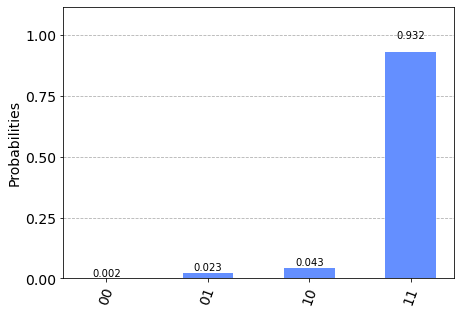

In [20]:
plot_histogram(counts)